# Gather Data From Paths and Save
Get all the data from the 27000 or so simulations and save to a CSV file that we can then do EDA on and think about preprocessing for models

## Setup

In [1]:
import s3fs
import zarr
import json
from tqdm import tqdm
import pandas as pd
import pickle
from pprint import pprint
import os, time
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
endpoint = 'https://wifire-data.sdsc.edu:9000'
access_key = os.getenv("ACCESS_KEY")
secret_key = os.getenv("SECRET_KEY")

fs = s3fs.S3FileSystem(key=access_key,
    secret=secret_key,
    client_kwargs={
        'endpoint_url': endpoint,
        'verify': False
    },
    skip_instance_cache=False
)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

name = 'quicfire.zarr'
bucket = 'burnpro3d/d'

root = list(fs.ls(bucket))

simulation_paths = []
print("successfully authenticated")

successfully authenticated


## Gather Data into DataFrame

In [49]:
def read_paths():
    paths = []
    with open("paths.txt","r") as f:
        paths = f.read().splitlines() 
    return paths

In [163]:
KEEP_ATTRIBUTES = {
    'path': lambda d: None,
    'time_scraped': lambda d: None,
    'canopy_moisture': lambda d: d['canopy_moisture'],
    'dz':lambda d: d['dz'],
    'extent': lambda d: d['extent'],
    'extent_fmt': lambda d: d['extent_fmt'],
    'fire_grid': lambda d: d['fire_grid'],
    'fuel': lambda d: d['fuel'],
    'ignition': lambda d: d['ignition'],
    'output': lambda d: d['output'],
    'resolution': lambda d: d['resolution'],
    'resolution_units': lambda d: d['resolution_units'],
    'run_binary': lambda d: d['run_binary'],
    'run_end': lambda d: d['run_end'],
    'run_max_mem_rss_bytes': lambda d: d['run_max_mem_rss_bytes'],
    'run_start': lambda d: d['run_start'],
    'seed': lambda d: d['seed'],
    'sim_time': lambda d: d['sim_time'],
    'surface_moisture': lambda d: d['surface_moisture'],
    'threads': lambda d: d['threads'],
    'timestep': lambda d: d['timestep'],
    'topo': lambda d: d['topo'],
    'wind_direction': lambda d: d['wind_direction'],
    'wind_speed': lambda d: d['wind_speed']
}

def get_df_chunk(stop):
    with open("vars.txt", "r") as file:
        start = int(file.read())
        print("start " , start)
    global simulation_paths, KEEP_ATTRIBUTES, incomplete, filenotfound

    df = pd.DataFrame([], columns=KEEP_ATTRIBUTES.keys())
    time = datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
    i = 0
    for p in tqdm(simulation_paths[start:stop]):
        try:
            with fs.open(p + '/' + name + '/.zattrs') as f:
                data=json.load(f)
        except:
            print("FileNotFound error on path {",p,"}")
            continue
            
        row = []
        for k,expr in KEEP_ATTRIBUTES.items():
            try:
                value = KEEP_ATTRIBUTES[k](data)
            except KeyError:
                value = None
            row.append(value)
        row[0] = p
        row[1] = time
        df.loc[i] = row
        i+=1
    with open("vars.txt", "w") as f:
            f.write(str(stop))
            print("\nRead from ", start, " to ", stop,"\n")
    return df

pd.set_option('display.max_columns', None)

In [164]:
simulation_paths = read_paths()
len(simulation_paths)

26997

In [170]:
BATCH_SIZE = 100

In [175]:

with open("vars.txt", "r") as file:
    start = int(file.read())

tic = time.perf_counter()
path_count = start + BATCH_SIZE
df = get_df_chunk(path_count)
toc = time.perf_counter()

df.head()
time_elapsed = f"{toc - tic:0.3f}"
print(f"Downloaded the dataframe chunk in {time_elapsed} seconds")


start  23100


  3%|█▎                                         | 3/100 [00:00<00:08, 11.39it/s]

FileNotFound error on path { burnpro3d/d/ee/39/run_ee3996fa-9c56-405e-aaa0-e8b6a1e6f424 }


 20%|████████▍                                 | 20/100 [00:03<00:12,  6.65it/s]

FileNotFound error on path { burnpro3d/d/ee/5f/run_ee5fc19e-fa5f-461a-bd1c-e9cd777acfe3 }


 30%|████████████▌                             | 30/100 [00:05<00:09,  7.29it/s]

FileNotFound error on path { burnpro3d/d/ee/91/run_ee91ff1b-8334-45b5-9097-293693ae6d9b }
FileNotFound error on path { burnpro3d/d/ee/92/run_ee929174-d0e9-4a48-8a0a-aba046a470f2 }


 47%|███████████████████▋                      | 47/100 [00:07<00:06,  7.86it/s]

FileNotFound error on path { burnpro3d/d/ee/c6/run_eec6ee32-4570-4413-a5c3-b33abab18121 }


 80%|█████████████████████████████████▌        | 80/100 [00:15<00:02,  6.96it/s]

FileNotFound error on path { burnpro3d/d/ef/1b/run_ef1b1f4b-c0d0-414d-84df-ea4c23ac3719 }


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


Read from  23100  to  23200 

Downloaded the dataframe chunk in 20.250 seconds


In [176]:
len(df)

94

In [177]:
print("raw length: ",len(df))
df = df.dropna(subset=["run_end", "run_start", "sim_time"])
print("length after dropna: ",len(df))
df = df[ (df['run_binary'] == "/quicfire/quicfire-v5.2-ucsd-rel") & (df['threads'] == 1)]
print("length after filter version and single threading: ",len(df)) 
df.head()

raw length:  94
length after dropna:  78
length after filter version and single threading:  12


,path,time_scraped,canopy_moisture,dz,extent,extent_fmt,fire_grid,fuel,ignition,output,resolution,resolution_units,run_binary,run_end,run_max_mem_rss_bytes,run_start,seed,sim_time,surface_moisture,threads,timestep,topo,wind_direction,wind_speed
5,burnpro3d/d/ee/45/run_ee455bc0-e900-4929-9954-...,2023-07-28T12:21:19.720857,0.9,None,"[-1398056.0, 2815704.0, -1397036.0, 2814900.0]","[[x1, y1], [x2, y2]]",None,None,None,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-19T11:39:47.855802-07:00,2551860,2023-06-19T09:25:12.644220-07:00,-1,7313,0.15,1,600,"{'topo_calcs': True, 'total_startup_iters': 500}",240.0,4.470
12,burnpro3d/d/ee/58/run_ee5889b7-1f62-4f41-8c57-...,2023-07-28T12:21:19.720857,0.9,None,"[-1398056.0, 2815704.0, -1397036.0, 2814900.0]","[[x1, y1], [x2, y2]]",None,None,None,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-19T16:43:23.538184-07:00,2565312,2023-06-19T13:23:17.131454-07:00,-1,6906,0.15,1,600,"{'topo_calcs': True, 'total_startup_iters': 500}",270.0,6.705
13,burnpro3d/d/ee/59/run_ee590e6f-ab53-40bf-94c0-...,2023-07-28T12:21:19.720857,1.0,None,"[-2011072.0, 1581140.0, -2010524.0, 1580484.0]","[[x1, y1], [x2, y2]]",None,None,None,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-07-10T15:08:04.227069-07:00,516552,2023-07-10T14:58:48.516813-07:00,-1,4228,0.07,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",300.0,2.235
17,burnpro3d/d/ee/5f/run_ee5fc972-f144-4edc-95a7-...,2023-07-28T12:21:19.720857,1.0,None,"[-2097480.0, 2037504.0, -2096674.0, 2036700.0]","[[x1, y1], [x2, y2]]",None,None,None,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-20T11:39:49.338648-07:00,3919052,2023-06-20T09:51:35.910785-07:00,-1,14997,0.08,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",360.0,4.470
22,burnpro3d/d/ee/71/run_ee719e17-f05e-4525-8dc4-...,2023-07-28T12:21:19.720857,1.0,None,"[-939420.0, 1474018.0, -938616.0, 1473212.0]","[[x1, y1], [x2, y2]]",None,None,None,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-07-18T14:13:57.162196-07:00,2275444,2023-07-18T13:28:52.106387-07:00,-1,5983,0.25,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",180.0,4.470


In [178]:
df.to_csv("simulation_runs.csv", mode="a",header=False)

# Now read the data and do some stuff!

In [34]:
data2 = pd.read_csv("simulation_runs.csv")
print(len(data2))
data2.head()

347


,Unnamed: 0,path,time_scraped,canopy_moisture,dz,extent,extent_fmt,fire_grid,fuel,ignition,output,resolution,resolution_units,run_binary,run_end,run_max_mem_rss_bytes,run_start,seed,sim_time,surface_moisture,threads,timestep,topo,wind_direction,wind_speed
0,38,burnpro3d/d/00/60/run_00601423-00ba-4edc-85de-...,2023-07-27T17:04:03.155927,1.00,NaN,"[-928246.0, 1477596.0, -927440.0, 1476900.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-20T16:44:36.032464-07:00,1934680,2023-06-20T15:13:20.118932-07:00,-1,4503,0.10,1,600,"{'topo_calcs': True, 'total_startup_iters': 500}",65.0,2.235
1,41,burnpro3d/d/00/6d/run_006d5586-0a9c-448a-b307-...,2023-07-27T17:04:03.155927,0.90,NaN,"[-2022346.0, 1581420.0, -2020914.0, 1580036.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-15T13:51:13.573728-07:00,2470180,2023-06-15T11:08:55.640920-07:00,-1,11382,0.05,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",90.0,4.470
2,77,burnpro3d/d/00/d5/run_00d57d95-2227-40ea-b1a8-...,2023-07-27T17:04:03.155927,0.95,NaN,"[-2011072.0, 1581140.0, -2010524.0, 1580484.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-27T16:12:51.127014-07:00,517424,2023-06-27T16:04:29.825894-07:00,-1,3937,0.12,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",270.0,2.235
3,10,burnpro3d/d/01/37/run_0137bb44-361e-48ed-8feb-...,2023-07-27T17:05:28.453250,1.10,NaN,"[885288.0, 870390.0, 886242.0, 869286.0]","[[x1, y1], [x2, y2]]",NaN,"{'density': None, 'dx': 2, 'dy': 2, 'height': ...","{'dat': None, 'id': '121dc89e-b034-479a-b0da-c...","{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-04-09T19:36:16.198481-07:00,2454040,2023-04-09T18:24:10.951246-07:00,-1,4921,0.10,1,600,NaN,137.0,3.000
4,14,burnpro3d/d/01/40/run_0140601b-6702-452f-8bc0-...,2023-07-27T17:05:28.453250,1.00,NaN,"[-2097480.0, 2037504.0, -2096674.0, 2036700.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,"{'emissions': False, 'energy_atmos': False, 'f...","[2.0, 2.0, 1.0]",meters,/quicfire/quicfire-v5.2-ucsd-rel,2023-06-20T12:23:45.540506-07:00,3919432,2023-06-20T09:53:36.922562-07:00,-1,14997,0.15,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",360.0,4.470


In [34]:
import ast

def calculate_area(L):
    #where p1 in the bottom left = (x1,y1) and p2 in the bottom left = (x2,y2)
 
    # Converting string to list
    res = ast.literal_eval(L)
    L = res
    x1, y1, x2, y2 = float(L[0]), float(L[1]), float(L[2]), float(L[3])
    print(x1, type(x1))
    x_length = abs(x2-x1)
    y_length = abs(y2-y1)
    area = x_length * y_length
    return area

In [65]:
# df = data2.get(["sim_time","run_end","run_start","extent","surface_moisture","timestep","wind_direction","wind_speed","canopy_moisture"])

# df['area'] = df.apply(lambda row: calculate_area(row["extent"]), axis=1)
# print(df['area'])

<Axes: xlabel='area', ylabel='sim_time'>

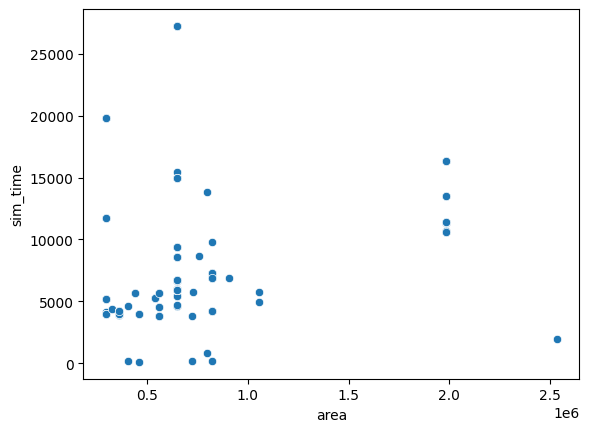

In [36]:
import seaborn as sns
sns.scatterplot(x=df['area'], y=df['sim_time'])